In [28]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD

In [100]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 500
LATENT_DIM = 25

In [5]:
input_text = []
output_text = []

In [10]:
for line in open("robert_frost.txt"):
    line = line.rstrip()
    if not line:
        continue
    input_line = "<sos> " + line ## Start of Sentence Token
    output_line = line + " <eos>" ## End of Sentence Token
    
    input_text.append(input_line)
    output_text.append(output_line)

all_lines = input_text + output_text

In [23]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE, filters = "") ## If filter not blank then it will remove Special Character
tokenizer.fit_on_texts(all_lines)

In [13]:
input_sequences = tokenizer.texts_to_sequences(input_text)
output_sequences = tokenizer.texts_to_sequences(output_text)

In [20]:
max_sequence_length_from_data = max(len(s) for s in input_sequences)

In [22]:
word2idx = tokenizer.word_index
assert("<sos>" in word2idx)
assert("<eos>" in word2idx)

In [25]:
max_sequence_length = min(MAX_SEQUENCE_LENGTH, max_sequence_length_from_data)
input_sequences = pad_sequences(input_sequences, maxlen = max_sequence_length, padding = "post")
output_sequences = pad_sequences(output_sequences, maxlen = max_sequence_length, padding = "post")

In [26]:
print("Shape of the Input tensor:", input_sequences.shape)

Shape of the Input tensor: (2872, 12)


In [27]:
print("Shape of the Output tensor:", output_sequences.shape)

Shape of the Output tensor: (2872, 12)


## Loading the Pre-Trained Word Vectors

In [29]:
word2vec = {}

In [35]:
with open("glove.6B.50d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype = "float32")
        word2vec[word] = vec
print("Found %s word vectors." % len(word2vec))    

Found 400004 word vectors.


In [39]:
word2vec["the"]

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

In [41]:
allwords = word2vec.items()

In [44]:
len(word2vec)

400004

In [43]:
len(allwords)

400004

In [87]:
num_words = min(MAX_VOCAB_SIZE, len(word2vec) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

In [89]:
num_words

3000

In [51]:
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [55]:
embedding_matrix[104]

array([ 0.58288997,  0.36258   ,  0.34064999,  0.36416   ,  0.34336999,
        0.79386997, -0.93620002,  0.11432   , -0.63005   , -0.55523998,
       -0.28705999, -0.47143   , -0.75673002,  0.63867998,  0.22479001,
       -0.64652002, -0.074314  , -0.34902999, -0.97285002, -0.53981   ,
        0.015171  ,  0.24479   ,  0.62660998,  0.070447  , -0.51629001,
       -1.20039999,  0.31220001, -0.44053   , -0.29868999, -0.56326002,
        4.02199984,  0.38462999, -0.028468  ,  0.068716  ,  1.07459998,
        0.48309001,  0.2475    ,  0.22802   , -0.35743001,  0.40391999,
       -0.54737997,  0.15244   ,  0.41      ,  0.15702   ,  0.0077935 ,
       -0.015106  , -0.28652999, -0.16158   , -0.35168999, -0.82555002])

## One Hot Targets

In [79]:
one_hot_targets = np.zeros((input_sequences.shape[0], max_sequence_length, num_words))

In [80]:
for i, target_sequence in enumerate(output_sequences):
    for t, word in enumerate(target_sequence):
        if word > 0:
           one_hot_targets[i, t, word] = 1

## Load pre-trained word embeddings into an Embedding layer

In [82]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix])

## Create an LSTM network with a single LSTM

In [96]:
input_ = Input(shape=(max_sequence_length,))  # Input sequence (e.g., a sentence in the source language)
initial_h = Input(shape=(LATENT_DIM,))        # Initial hidden state for the LSTM
initial_c = Input(shape=(LATENT_DIM,))        # Initial cell state for the LSTM

# Pass the input through an embedding layer to get dense word embeddings
x = embedding_layer(input_)

# Define an LSTM with the initial state (initial_h, initial_c)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c])  # Encoder output (x) with updated state

# Dense layer to produce the vocabulary-size output with a softmax activation for probabilities
dense = Dense(num_words, activation="softmax")
output = dense(x)

In [91]:
model = Model([input_, initial_h, initial_c], output)

#### Initial Hidden and Cell States (initial_h, initial_c):

- Purpose: In the encoder-decoder setup, we set initial_h and initial_c to zeros or other predefined values. Once trained, these initial states will allow the encoder to condition its output on the prior sequence state.
- Why we define them: These states allow us to pass the "memory" of the encoder into the decoder. For example, if we initialize an LSTM with [0, 0] as the hidden and cell states, the LSTM will output based on just the input sequence. If we initialize it with non-zero states, it will factor those in as context.

In [94]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(learning_rate = 0.01),
    metrics = ["accuracy"])

## Training the Model

In [101]:
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
    [input_sequences, z, z],
    one_hot_targets,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT)

Epoch 1/500
18/18 [==============================] - 3s 138ms/step - loss: 1.6054 - accuracy: 0.3733 - val_loss: 1.9626 - val_accuracy: 0.3022
Epoch 2/500
18/18 [==============================] - 2s 130ms/step - loss: 1.5980 - accuracy: 0.3755 - val_loss: 1.9539 - val_accuracy: 0.3051
Epoch 3/500
18/18 [==============================] - 2s 132ms/step - loss: 1.5959 - accuracy: 0.3761 - val_loss: 1.9573 - val_accuracy: 0.3029
Epoch 4/500
18/18 [==============================] - 2s 125ms/step - loss: 1.5902 - accuracy: 0.3774 - val_loss: 1.9416 - val_accuracy: 0.3059
Epoch 5/500
18/18 [==============================] - 2s 122ms/step - loss: 1.5830 - accuracy: 0.3782 - val_loss: 1.9399 - val_accuracy: 0.3077
Epoch 6/500
18/18 [==============================] - 2s 123ms/step - loss: 1.5763 - accuracy: 0.3795 - val_loss: 1.9272 - val_accuracy: 0.3104
Epoch 7/500
18/18 [==============================] - 2s 128ms/step - loss: 1.5730 - accuracy: 0.3811 - val_loss: 1.9370 - val_accuracy: 0.3070

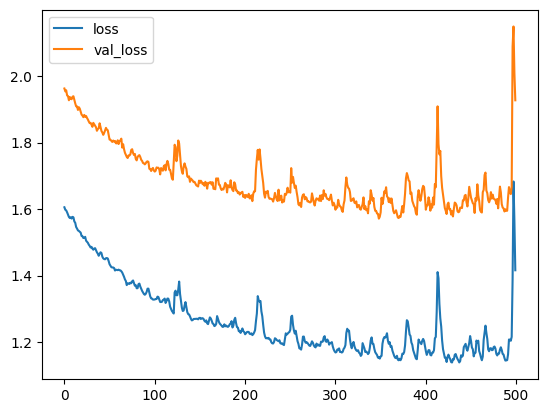

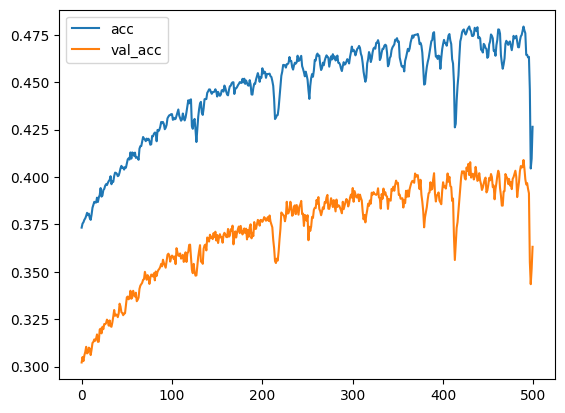

In [102]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

## Make a sampling model

In [103]:
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [104]:
idx2word = {v:k for k, v in word2idx.items()}

In [105]:
def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])

    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accuulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)

In [106]:
while True:
  for _ in range(4):
    print(sample_line())

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break

1/1 [==============================] - 0s 40ms/step
digged.' to. (nine gives tribe love, bones, 'aren't gives estelle hall road,
1/1 [==============================] - 0s 30ms/step
men other, idea.' leaf's 'company?' until for robinson, reason. charred anyway. what's
1/1 [==============================] - 0s 31ms/step
sake, gun upper sure home: licked slight, button,' broken, idea.' pine, flying
1/1 [==============================] - 0s 32ms/step
remoteness wait. having paint, live stampede, folks iron paint, poems. race children.


---generate another? [Y/n]--- n
